# DARPA SUBOFF Actuator Disk

This notebook demonstrates the setup of an actuator disk in Flow360 using the DARPA SUBOFF geometry, configured for liquid operating conditions. The actuator disk is positioned at the aft end of the hull.

![DARPA SUBOFF geometry](figures/darpa_geo.png)

## 1. Create Project from geometry
Load Python libraries that are used throughout the notebook and Flow360 client.
For this project we are starting from the geometry of the DARPA SUBOOF model. The geometry file is in the class `DARPA_SUBOFF` as a download link which gets the STEP file "DARPA.STEP". To use your own geometry, replace the file path in `from_geometry` with the path to your CAD file.

In [1]:
import flow360 as fl
from flow360.examples.DARPA import DARPA_SUBOFF

import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import trapezoid

DARPA_SUBOFF.get_files()
project = fl.Project.from_geometry(
    DARPA_SUBOFF.geometry,
    name="Tutorial DARPA Actuator Disk from Python",
)
geo = project.geometry
geo.group_faces_by_tag("faceId")  # group faces by faceId

Output()

[18:39:04] INFO: Geometry successfully submitted:                                                                  
                   type        = Geometry                                                                          
                   name        = Tutorial DARPA Actuator Disk from Python                                          
                   id          = geo-7ea014e6-f3bf-4c62-93f5-2948353298ca                                          
                   status      = uploaded                                                                          
                   project id  = prj-1e0d7228-0bbd-4812-ab63-ab57633b87ef                                          
           

           INFO: Waiting for geometry to be processed.

Output()

[18:39:39] INFO: Regrouping face entities under `faceId` tag (previous `groupByBodyId`).

## 2. Define Actuator Disk
To define the actuator disk these steps are required:
- Find force distribution along the radius of the actuator disk.
- Define a volume zone where the actuator disk where the volumetric forces are applied inside the solver iterations. This zone can intersect any surface and only the nodes in the fluid zone will be affected. If an inner surface is present (like in this case), it is recommended to place the inner radius of the actuator disk volume to intersect with the surface. This is to prevent a hub vortex to appear close to the surface due to jump in pressure forces at the hub, creating circulating regions not realistic.
- Define an axisymmetric refinement inside the actuator disk region to properly capture the volumetric forces discontinuities. This refinement cannot intersect any surface.

Optionally:
- Add volumetric refinements around the actuator disk for proper wake capturing.
- Add surface refinements close to the actuator disk inner radius.

### 2.1 Find force distributions
The axial and circumferential force distributions are the external pressure forces that are applied to each control volume over the actuator disk radius. The input for the actuator disk is a pressure distribution. Axial distribution will act on the axial momentum creating a downwash and circumferential distribution will act perpendicular to the axial direction by adding a swirl velocity on the wake. These distributions can be found from two sources:
- Radial thrust and torque distributions provided from manufacturer or measured experimentally. For this cases, we need to convert the thrust and torque distributions to pressure distributions.
- Approximated distributions based from total thrust and torque. These approximations range from simple uniform distributions to more advanced analytical formulations based on vortex theory.

First, we define the geometry of the rotor and operating conditions:

In [2]:
# Define geometry
R_out = 0.3  # Outer radius of the actuator disk
R_hub = 0.0597 / 2  # Blade root radius
R_in = (
    R_hub * 0.98
)  # Inner radius of the actuator disk, smaller than the blade root radius to prevent hub vortex affecting the surface flow
NBlades = 5  # Number of blades

# Define operating conditions
thrust = 2000  # Thrust force
torque = 100  # Torque force
omega = 100 * 2 * np.pi / 60  # Rotation rate
rho = 1000  # Density
Uinf = 5  # Freestream velocity

**If thrust and torque radial distributions are given:**

We would read the data from a dataset and convert the force distribution to pressure distribution. However, for this example, we assume a triangular distribution with a maximum value at 70% radial location for both of them. We follow this method:

In [3]:
# Read or input the thrust and torque radial distributions
r_from_data = [R_in, R_out * 0.7, R_out]
thrust_max = (2 * thrust) / (R_out - R_in)
torque_max = (2 * torque) / (R_out - R_in)
thrust_radial = [0, thrust_max, 0]  # Triangular distribution
torque_radial = [0, torque_max, 0]  # Triangular distribution

# Convert to pressure force distributions
r_from_data = np.array(r_from_data)
thrust_radial_from_data = np.array(thrust_radial)
torque_radial_from_data = np.array(torque_radial)
f_ax_from_data = thrust_radial_from_data / (2 * np.pi * r_from_data)
f_cir_from_data = torque_radial_from_data / (2 * np.pi * r_from_data**2)

**If thrust and torque radial distributions are not given:**

We can approximate with a realistic distribution from the Betz-Prandtl vortex theory described [here](https://simcloud-public-1.s3.amazonaws.com/publications/Electra_Joint_Paper/Electra_FC_Impact_of_Propulsion_Modeling_Approach_on_High_Lift_Force_Prediction_of_Propeller_Blown_Wings.pdf).

In [4]:
# Radial discretization
n_points = 200
r_theory = np.linspace(R_in, R_out, n_points)
xi = r_theory / R_out

# Step 1: Compute axial velocity through disk
v_ax = 0.5 * (np.sqrt((2 * thrust) / (rho * np.pi * R_out**2) + Uinf**2) + Uinf)

# Step 2: Wake advance ratio
lambda_w = v_ax / (omega * R_out)

# Step 3: Compute Prandtl tip-loss and hub-loss functions
f_tip = (NBlades / 2) * (1 - xi) * np.sqrt(1 + 1 / lambda_w**2)
f_hub = (NBlades / 2) * (xi - R_in / R_out) * np.sqrt(1 + 1 / lambda_w**2)
F_tip = (2 / np.pi) * np.arccos(np.exp(-f_tip))
F_hub = (2 / np.pi) * np.arccos(np.exp(-f_hub))
F = F_tip * F_hub

# Step 4: Non-dimensional circulation (Gamma_1)
gamma_tmp = (F * xi**2) / (lambda_w**2 + xi**2)

# Step 5: Compute local body forces per unit area
f_ax = NBlades * (rho * omega * gamma_tmp) / (2 * np.pi)
f_cir = NBlades * (rho * v_ax * gamma_tmp) / (2 * np.pi * r_theory)

# Step 6: Scale thrust and torque
integrand_thrust = f_ax * 2 * np.pi * r_theory
integrand_torque = f_cir * r_theory * 2 * np.pi * r_theory
thrust_tmp = trapezoid(integrand_thrust, r_theory)
torque_tmp = trapezoid(integrand_torque, r_theory)
K_thrust = thrust / thrust_tmp
K_torque = torque / torque_tmp
f_ax_from_theory = K_thrust * f_ax
f_cir_from_theory = K_torque * f_cir

As a final step we define the pressure distributions that will be used for the actuator disk model. Furthermore, we can check that our distributions give the desired total thrust and torque by integrating them over the radius.

In [5]:
data_is_given = False
if data_is_given:
    r = r_from_data
    f_ax = f_ax_from_data
    f_cir = f_cir_from_data
else:
    r = r_theory
    f_ax = f_ax_from_theory
    f_cir = f_cir_from_theory

thrust_check = trapezoid(
    f_ax * 2 * np.pi * r, r
)  # Pressure force integrated over the radius
torque_check = trapezoid(
    f_cir * r * 2 * np.pi * r, r
)  # Pressure force integrated over the radius

print(f"Desired thrust: {thrust}, computed thrust: {thrust_check}")
print(f"Desired torque: {torque}, computed torque: {torque_check}")

Desired thrust: 2000, computed thrust: 2000.0000000000002
Desired torque: 100, computed torque: 100.00000000000003


### 2.2 Define volumetric zone for the actuator disk
In this zone the volumetric source termns will be applied. The actuator disk is aligned in the x-direction and is centered around x = 4.2609 m. The height of the actuator disk is recommended to be 10% of the outer radius. The inner radius is smaller than the blade root radius to prevent the artificial hub vortex to affect the surface flow.

**The pressure distributions found previously are used here.**

In [6]:
with fl.SI_unit_system:
    x_AD = 4.2609  # x-location of the actuator disk center
    AD_zone = fl.Cylinder(
        name="AD",
        axis=(1, 0, 0),
        center=(x_AD, 0, 0),
        inner_radius=R_in,
        outer_radius=R_out,
        height=R_out * 0.1,
    )

    AD_model = fl.ActuatorDisk(
        name="AD_model",
        volumes=AD_zone,
        force_per_area=fl.ForcePerArea(
            radius=r,
            thrust=f_ax,
            circumferential=f_cir,
        ),
    )

           INFO: using: SI unit system for unit inference.

### 2.3 Define the axisymmetric refinement
The zone where the actuator disk model is applied will be discretised with a structured cylindrical mesh. This results in a more accurate discretisation since the nodes are aligned with the strong gradients. It is recommended to place >= 30 nodes in the axial direction and x2 spatial distance in the radial and circumferential directions. For higher disk loading cases this values will change with more nodes required the higher the disk loading.

In [7]:
d_axial = R_out * 0.1 / 30  # 30 nodes in the axial direction
d_radial = d_axial * 2  # x2 spatial distance in the radial direction
d_circumferential = d_axial * 2  # x2 spatial distance in the circumferential direction

The surface close to the inner radius of this region will grow layers until the growth is stopped due to the presence of the refinement. Depending on the surface elements length and the axisymmetric refinement spacings, this can lead to bad quality meshes close to the surface. Therefore, the inner radius for this region must be chosen with care since we want to accurately predict the boundary layer but also have the axisymmetric refinement.

One solution is to force a number of layers that we want to have between the surface and the refinement region by changing the inner radius of the axisymmetric refinement. The amount of layers needed until isotropy is influenced by the first layer thickness, surface element length and the growth rate so playing with these values will give the desired mesh.

In [8]:
first_layer_thickness = 1e-5
growth_rate = 1.2
surface_elements_length = 0.001
n_layers = 20

total_height = first_layer_thickness * growth_rate**n_layers

inner_radius = R_hub + total_height

We can now define the axisymmetric refinement region which has a modified inner radius to fit the specified layers.

In [9]:
with fl.SI_unit_system:
    refinements = [
        fl.AxisymmetricRefinement(
            name="AD_axisym",
            spacing_axial=d_axial,
            spacing_radial=d_radial,
            spacing_circumferential=d_circumferential,
            entities=[
                fl.Cylinder(
                    name="AD_axisym",
                    axis=(1, 0, 0),
                    center=(x_AD, 0, 0),
                    inner_radius=inner_radius,
                    outer_radius=R_out,
                    height=R_out * 0.1,
                ),
            ],
        )
    ]

           INFO: using: SI unit system for unit inference.

### 2.4 Surface and Volume Refinements
It is possible to use surface refinements to force the maximum surface element length between the surface and the axisymmetric refinement and control the number of layers to fit. Additionally, the influence of the actuator disk wake on the surface will be captured more accurately.

Besides, volumetric refinements around the actuator disk volume region will capture the wake with more accuracy.

In [10]:
with fl.SI_unit_system:
    faces_close_to_AD = [
        geo[f"body00001_face000{n:02d}"] for n in [2, 4, 19, 21]
    ]  # Surface faces close to axisymmetric refinement
    surface_refinement = fl.SurfaceRefinement(
        name="surface_refinement",
        max_edge_length=1 * fl.u.mm,
        faces=faces_close_to_AD,
    )

    height = R_out * 3  # Height of the volume refinement
    front_space = (
        R_out * 0.5
    )  # Space in front of the actuator disk to the volume refinement
    center_volume = x_AD + (height / 2 - front_space)
    volume_refinement = fl.UniformRefinement(
        name="volume_refinement",
        spacing=10 * fl.u.mm,
        entities=[
            fl.Cylinder(
                name="volume_refinement",
                axis=(1, 0, 0),
                center=(center_volume, 0, 0),
                outer_radius=R_out * 1.5,
                height=height,
            )
        ],
    )

    L = 4.3562
    height_general = L * 2
    front_space_general = 0.5
    center_general = height_general / 2 - front_space_general
    general_refinement = fl.UniformRefinement(
        name="general_refinement",
        spacing=20 * fl.u.mm,
        entities=[
            fl.Cylinder(
                name="general_refinement",
                axis=(1, 0, 0),
                center=(center_general, 0, 0),
                outer_radius=R_out * 2,
                height=height_general,
            )
        ],
    )
    refinements += [
        surface_refinement,
        volume_refinement,
        general_refinement,
    ]

           INFO: using: SI unit system for unit inference.

The mesh looks like:

![DARPA MESH](figures/DARPA_mesh.png)

Taking a zoom view around the axisymmetric refinement close to the hull we can visually check that the specified number of layers to fit inside the gap between the outer radius of the hull and the inner radius of the refinement is correct.

![DARPA MESH ZOOM](figures/DARPA_zoom_mesh.png)

## 4. Use Liquid Condition

For this example we want to simulate the veihcle in free water conditions. To do this, the class fl.LiquidOperatingCondition() is used:

In [11]:
with fl.SI_unit_system:
    operating_condition = fl.LiquidOperatingCondition(
        velocity_magnitude=5, alpha=0 * fl.u.deg
    )

           INFO: using: SI unit system for unit inference.

## 5. Define SimulationParams
- The simulation parameters are defined in the python class fl.SimulationParams()
- Reference geometry for the non-dimensionalisation of the coefficients are specified
- Operating conditions are specified using LiquidOperating condition.
- Time settings are defined to run a steady simulation.
- Actuator Disk model is included in the model definitions.

In [12]:
with fl.SI_unit_system:
    farfield = fl.AutomatedFarfield()
    params = fl.SimulationParams(
        meshing=fl.MeshingParams(
            defaults=fl.MeshingDefaults(
                boundary_layer_first_layer_thickness=first_layer_thickness,
                surface_max_edge_length=20 * fl.u.mm,
            ),
            refinements=refinements,  # All refinements previously defined
            volume_zones=[farfield],  # Farfield volume zone
        ),
        operating_condition=operating_condition,  # Liquid operating condition
        time_stepping=fl.Steady(max_steps=5000),
        models=[
            fl.Fluid(
                navier_stokes_solver=fl.NavierStokesSolver(),
                turbulence_model_solver=fl.SpalartAllmaras(),
            ),
            fl.Freestream(surfaces=farfield.farfield),
            fl.Wall(surfaces=geo["*"]),
            AD_model,  # Actuator disk model
        ],
        reference_geometry=fl.ReferenceGeometry(
            moment_center=(0, 0, 0),
            moment_length=(3.81, 3.81, 3.81),
            area=45.604,
        ),
        outputs=[
            fl.VolumeOutput(
                output_fields=[
                    "primitiveVars",
                    "Cp",
                    "qcriterion",
                ],
            ),
            fl.SurfaceOutput(
                surfaces=geo["*"],
                output_fields=[
                    "primitiveVars",
                    "Cp",
                    "Cf",
                    "CfVec",
                    "yPlus",
                ],
            ),
        ],
    )

           INFO: using: SI unit system for unit inference.

## 6. Run Case
Run the case specifying parameters and the case name.

In [13]:
case = project.run_case(
    params=params,
    name="Tutorial DARPA Actuator Disk from Python",
)

           INFO: using: SI unit system for unit inference.

[18:39:42] INFO: Successfully submitted:                                                                           
                   type        = Case                                                                              
                   name        = Tutorial DARPA Actuator Disk from Python                                          
                   id          = case-6337cdee-581f-4de8-b5a6-bee5d5a056c5                                         
                   status      = pending                                                                           
                   project id  = prj-1e0d7228-0bbd-4812-ab63-ab57633b87ef                                          
           

## 7. Post Processing
Once the simulation is finished, we will monitor the convergence of residuals over the pseudo steps:


Output()

Output()

[18:59:44] INFO: Saved to /tmp/tmpj7e_g3z5/ec479287-4853-42ac-91f1-1c88e91f68f8.csv

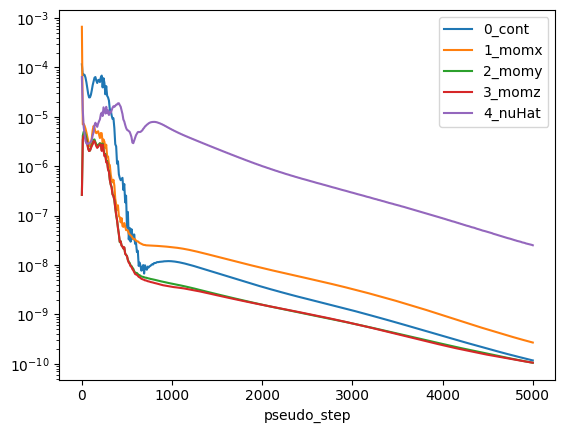

In [14]:
case.wait()
results = case.results
non_linear = results.nonlinear_residuals
non_linear = non_linear.as_dataframe()
non_linear.plot(
    "pseudo_step", ["0_cont", "1_momx", "2_momy", "3_momz", "4_nuHat"], logy=True
)
plt.show()

Then, we can monitor the drag force on the hull and also compute the actuator disk thrust and torque. To do so, we need to dimensionalise the forces based on the case reference quantities like length, density, reference velocity and area. Note that here the reference velocity for actuator disk output is the reference velocity magnitude and if this is not defined, then, the velocity magintude. This is the case since we are using `LiquidOperationCondition`, if we use `AerospaceCondition` then the reference velocity is the speed of sound.

In [15]:
# Get the reference quantities
length_unit = project.length_unit
density = case.params.operating_condition.material.density
U_ref = (
    case.params.operating_condition.reference_velocity_magnitude
    or case.params.operating_condition.velocity_magnitude
)
A_ref = case.params.reference_geometry.area

# Body force coefficients
body_forces = case.results.total_forces.as_dataframe().iloc[-1]
CD = body_forces["CD"]

# Actuator disk force coefficients
actuator_disk_output = case.results.actuator_disks.as_dataframe().iloc[-1]
C_p = actuator_disk_output["Disk0_Power"]
C_t = actuator_disk_output["Disk0_Force"]
C_q = actuator_disk_output["Disk0_Moment"]

# Dimensionalise the forces
drag_force = (CD * 0.5 * density * U_ref**2 * A_ref).to("N")
power = (C_p * density * U_ref**3 * length_unit**2).to("W")
thrust = (C_t * density * U_ref**2 * length_unit**2).to("N")
torque = (C_q * density * U_ref**2 * length_unit**3).to("N*m")

print(f"Drag force: {drag_force}")
print(f"Power: {power}")
print(f"Thrust: {thrust}")
print(f"Torque: {torque}")

Output()

[18:59:45] INFO: using: SI unit system for unit inference.

Output()

[18:59:47] INFO: Saved to /tmp/tmpj7e_g3z5/540c040a-d87f-43e7-8795-8edceb0a8556.csv

Output()

[18:59:48] INFO: Saved to /tmp/tmpj7e_g3z5/b3555311-949c-4876-b99f-db2b29eaff03.csv

Drag force: 123.54154537639587 N
Power: -6708.838415359351 W
Thrust: 1998.5858964461652 N
Torque: -99.92991479176999 N*m
